# Linear LFM

Replication of the paper by [Lawrence et al., 2006.](https://papers.nips.cc/paper/3119-modelling-transcriptional-regulation-using-gaussian-processes.pdf)

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

### Probesets

The original paper restricted their interest to 5 known targets of p53:

| Target       | Probeset     | Aliases    |
| :------------- | :----------: | :----------- |
| DDB2 |  203409_at    | |
| p21   | 202284_s_at | p21CIP1, CDKN1A |
| SESN1/hPA26   | 218346_s_at |  |
| BIK   | 205780_at |  |
| TNFRSF10b   | 209294_x_at, 209295_at, 210405_x_at |  |

In [1]:
import torch
import numpy as np
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from matplotlib import pyplot as plt
from os import path

from lafomo.models import ExactLFM
from lafomo.trainers import ExactTrainer
from lafomo.datasets import P53Data, ToyTranscriptomicGenerator
from lafomo.plot import Plotter
from lafomo.utilities.data import p53_ground_truth
from experiments.mae import get_datasets

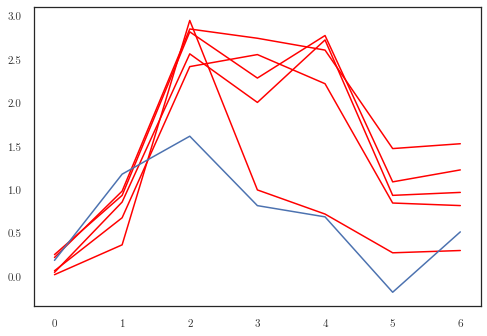

In [10]:
p53 = True

if p53:
    dataset = P53Data(replicate=0, data_dir='../../../data/')
    ground_truth = p53_ground_truth()
    class ConstrainedTrainer(ExactTrainer):
        def after_epoch(self):
            super().after_epoch()
            with torch.no_grad():
                sens = self.lfm.covar_module.sensitivity
                sens[3] = np.float64(1.)
                deca = self.lfm.covar_module.decay
                deca[3] = np.float64(0.8)
                self.lfm.covar_module.sensitivity = sens
                self.lfm.covar_module.decay = deca

else:
    datasets = get_datasets(data_dir='../../..')
    dataset = datasets[5]
    # dataset.generate_single(lengthscale=1.3)
    print(dataset.m_observed.shape)
    # dataset = ToyTranscriptomics(data_dir='../../../data/')
    dataset.variance = 1e-4 * torch.ones(dataset.m_observed.shape[-1], dtype=torch.float32)

    ground_truth = [
        dataset.lfm.basal_rate.detach().view(-1).numpy(),
        dataset.lfm.sensitivity.detach().view(-1).numpy(),
        dataset.lfm.decay_rate.detach().view(-1).numpy()
    ]
    class ConstrainedTrainer(ExactTrainer):
        def after_epoch(self):
            with torch.no_grad():
                sens_fixed = dataset.lfm.sensitivity[0].squeeze().numpy()
                dec_fixed = dataset.lfm.decay_rate[0].squeeze()
                sens = self.lfm.covar_module.sensitivity
                sens[0] = np.float64(sens_fixed)
                deca = self.lfm.covar_module.decay
                deca[0] = np.float64(dec_fixed)
                self.lfm.covar_module.sensitivity = sens
                self.lfm.covar_module.decay = deca
            super().after_epoch()


for i in range(5):
    plt.plot(dataset.m_observed[0, i], color='red')
plt.plot(dataset.f_observed[0, 0])

In [11]:
model = ExactLFM(dataset, dataset.variance.reshape(-1))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = ExactMarginalLogLikelihood(model.likelihood, model)

track_parameters = [
    'mean_module.raw_basal',
    'covar_module.raw_decay',
    'covar_module.raw_sensitivity',
    'covar_module.raw_lengthscale',
]


trainer = ConstrainedTrainer(model, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)
plotter = Plotter(model, dataset.gene_names)

In [12]:
model.likelihood.train()
a = trainer.train(epochs=50, report_interval=25)
a = np.array(a)

Epoch 001/050 - Loss: 1.20 (1.20) λ: [2.4933224]
Epoch 026/050 - Loss: 1.05 (1.05) λ: [2.412477]


tensor([[2.8876]], grad_fn=<AddBackward0>)
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])
MultivariateNormal(loc: torch.Size([1, 80]), covariance_matrix: torch.Size([1, 80, 80]))


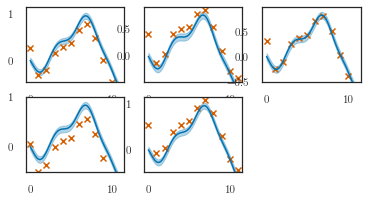

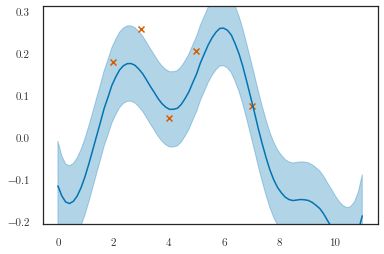

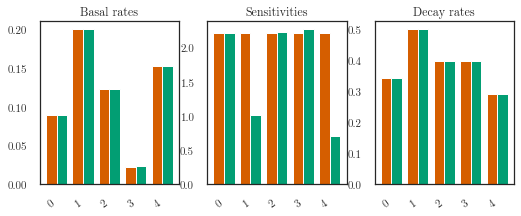

In [59]:
print(model.covar_module.lengthscale)
print(dataset.t_observed)
t_predict = torch.linspace(0, 11, 80, dtype=torch.float64)
p_m = model.predict_m(t_predict, jitter=1e-3)
p_f = model.predict_f(t_predict, jitter=1e-3)

plotter.plot_gp(p_m, t_predict,
                t_scatter=dataset.t_observed, y_scatter=dataset.m_observed)

plotter.plot_gp(p_f, t_predict,
                # ylim=(-2, 2.2),
                t_scatter=dataset.t_observed, y_scatter=dataset.f_observed, num_samples=0)

labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
constraints = dict(model.named_constraints())
for key in ['mean_module.raw_basal', 'covar_module.raw_sensitivity', 'covar_module.raw_decay']:
    val = trainer.parameter_trace[key][-1].squeeze()
    if key + '_constraint' in constraints:
        val = constraints[key + '_constraint'].transform(val)
    kinetics.append(val.numpy())

plotter.plot_double_bar(kinetics, labels, ground_truths=ground_truth)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.0053e-01,  2.9160e-01,  3.2730e-01,  ..., -3.9477e-03,
         -2.5421e-03, -1.6180e-03],
        [-7.9201e-01, -4.7376e-01, -1.9411e-01,  ..., -1.6506e-03,
         -1.0725e-03, -6.8861e-04],
        ...,
        [ 3.1279e-01,  1.5831e-01,  3.7735e-02,  ...,  3.1285e-03,
          2.0280e-03,  1.2993e-03],
        [-1.3769e-01, -6.4125e-02, -8.1872e-03,  ..., -1.6398e-03,
         -1.0537e-03, -6.6922e-04],
        [ 3.0094e-02,  8.6822e-03, -6.6855e-03,  ..., -1.8995e-04,
         -1.4144e-04, -1.0234e-04]], dtype=torch.float64,
       grad_fn=<CholeskySolveBackward>)
tensor(1.0005, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0005, dtype=torch.float64, grad_fn=<MinBackward1>)
tensor([[9.9536e-01, 9.9213e-01, 9.7748e-01,  ..., 8.7668e-06, 5.7131e-06,
         3.6785e-06],
        [9.9213e-01, 9.9876e-01, 9.9410e-01,  ..., 4.1083e-06, 2.6814e-06,
         1.7290

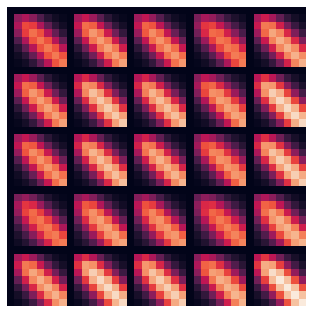

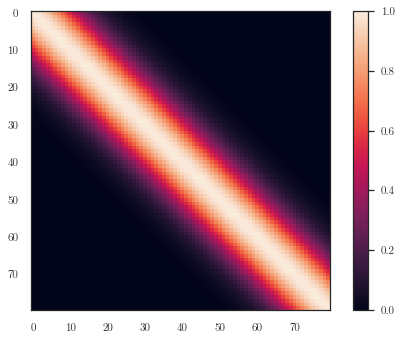

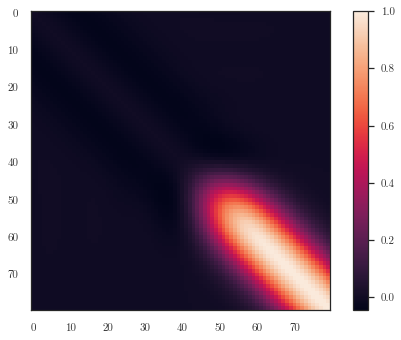

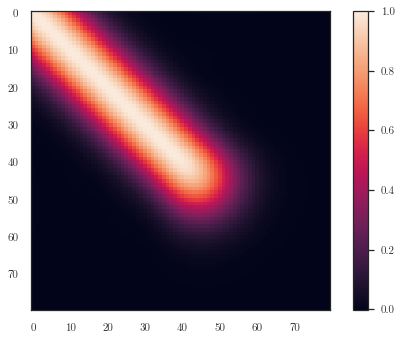

In [8]:
from matplotlib import pyplot as plt

Kxx = model.covar_module(model.train_t, model.train_t).evaluate()

plt.figure()
plt.imshow(Kxx.detach())
plt.axis('off')

Kxf = model.covar_module.K_xf(model.train_t, t_predict).type(torch.float64)

Kfx = torch.transpose(Kxf, 0, 1)
L = torch.cholesky(Kxx)

KxxKxf = torch.cholesky_solve(Kxf, L, upper=False)

# K_inv = torch.inverse(Kxx)

print(KxxKxf)
# KfxKxx = torch.matmul(torch.transpose(Kxf, 0, 1), K_inv)
# print(KfxKxx)
# mu = torch.matmul(KfxKxx, model.train_y).view(-1)
# plt.figure()
# plt.plot(mu.detach())

Kff = model.covar_module.K_ff(t_predict, t_predict)  # (100, 500)
plt.figure()
plt.imshow(Kff.detach())
plt.colorbar()
var = Kff - torch.matmul(Kfx, KxxKxf)
print(torch.diagonal(torch.matmul(Kfx, KxxKxf)).max())
print(torch.diagonal(var).min())
plt.figure()
plt.imshow(var.detach())
plt.colorbar()

plt.figure()
kfxf = torch.matmul(Kfx, KxxKxf)
print(kfxf)
plt.imshow(kfxf.detach())
plt.colorbar()

